<a href="https://colab.research.google.com/github/jnerenberg/jnerenberg.github.io/blob/main/Copy_of_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Applications of Word Embeddings
In this homework assignment, we will be exploring word embeddings through the implementation of algorithms from two recent papers:
* Word Embedding Bias ([Based on "Semantics derived automatically from language corpora contain human-like biases" by Aylin Caliskan, Joanna J. Bryson, and Arvind Narayanan (2017)](https://www.science.org/doi/10.1126/science.aal4230))
* Language Change ([Based on "Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora" by Hila Gonen, Ganesh Jawahar, Djamé Seddah, and Yoav Goldberg (2020)](https://aclanthology.org/2020.acl-main.51.pdf))

The algorithms that you're asked to implement for this assignment are rather simple compared to something like the Viterbi algorithm. Accordingly, one of the main goals of this assignment is to **develop your ability to read documentation** to figure out how the gensim library works, which will likely take some time. This is an important skill to develop as a programmer, and will also be useful at the end of the semester when you are working on your final project.

We are implementing this project in a Colab notebook for two reasons:
* It can be difficult to manage python libraries on your personal computer.
* It is very easy to experiment in Colab. You can test out a code snippet that you see in documentation or view a plot that you create with ease.

Colab does have some downsides, notably that working with files can be a bit difficult. I've added instructions for how to upload your files. **Note that you may need to do this multiple times if you take a break.**

## Important Formatting/Grading Note
You will be graded based on five functions (`gender_association_score`, `plot_workers_vs_association`, `train_w2v_embeddings`, `compute_semantic_change_scores`, and `most_semantic_change`). To test your code and complete your report, you will also write some code additional code outside of those functions and download some large files.

I don't want to download those large data files and run all of your test code on the autograder, so I am automatically parsing your file to extract your function definitions and relevant imports. If your code is imported directly, the test code will run, as it is not with in a `__name__ == "__main__"` condition. There are comments that I am using when parsing that you should not change, and you need to follow the instructions laid out in them.

#### TLDR
The cells that you'll write your functions in look like this. Only write your functions and import functions that you are calling from libraries in this cell. If you add testing code, the autograder will be slow and/or break.

```python
# TASK 1.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR gender_association_score FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

import stuff

def my_function():
  return "hello"

# TASK 1.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.
```

### Imports and Downloads
Run the cell below to import the main library we'll be working with (`gensim`).

In [1]:
import gensim

You can download the data for the homework assignment [here](https://drive.google.com/file/d/1Cet_dVtdI3aZR4Z2RNQh1CSVbjexNq3c/view?usp=drive_link)

Follow these instructions to upload the data to Colab:

* Click on the "Files" icon:
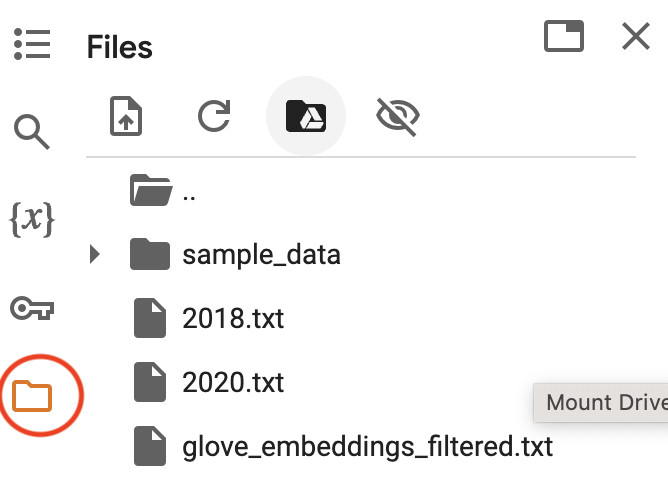</img>

* Click on the Upload icon:
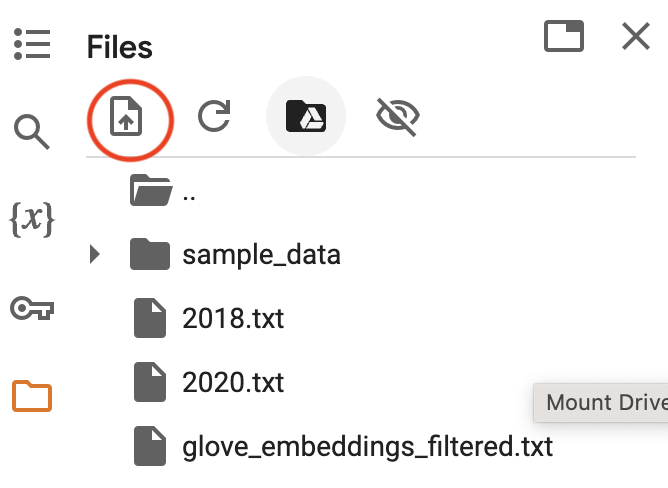</img>

* Upload all three files: 2018.txt, 2020.txt, and glove_embeddings_filtered.txt.

_You may have to do this again if you take a break and come back to the notebook. If you prefer, you can set up your notebook to use google drive following [these instructions](https://colab.research.google.com/notebooks/io.ipynb)._

## Application 1: Word Embedding Bias

First, we will be exporing how computational representations of language reflect human biases by re-creating a plot from the paper [Semantics derived automatically from language corpora contain human-like biases](https://www.science.org/doi/10.1126/science.aal4230) by Aylin Caliskan, Joanna J. Bryson, and Arvind Narayanan. In particular, we will determine whether embeddings of female-associated words (like `"female"` or `"woman"`) are more similar to embeddings of professions in which there are more women (like `"hairdresser"`) and vise-versa for male associated words (like `"male"` or `"men"`) and professions in which there are more men (like `"electrician"`). It is worth noting that this method is limited in that it only considers binary gender and uses simple sets of words to represent "men" and "women".


The cell below contains the data that you'll need for this part of the assignment:
* `PROFESSIONS`: a dictionary mapping professions fo the percentage of female workers
* `FEMALE_WORDS`: a set of female-associated words
* `MALE_WORDS`: a set of male-associated words

These are taken from the supplemental material that was distributed with the paper.

This cell also loads the GloVe embeddings that were used in the paper and stores them using the gensim `KeyedVectors` class. I've created a smaller file that contains the embeddings that you need, as the original with the full vocabulary is multiple gigabytes and takes a long time to download.

In [2]:
PROFESSIONS = {
  "pharmacist": 0.57, "practitioner": 0.7478910505836575,
  "administrator": 0.5485859564164649, "counselor": 0.6648148148148149,
  "instructor": 0.623, "janitor": 0.34299999999999997, "hygienist": 0.964,
  "pathologist": 0.986, "scientist": 0.419448275862069, "baker": 0.608,
  "advisor": 0.379, "carpenter": 0.020729306487695748,
  "paralegal": 0.8540000000000001, "architect": 0.20809148264984223,
  "programmer": 0.18350704225352113, "technician": 0.40340564671814666,
  "mechanic": 0.017982375478927202, "engineer": 0.10722061694650525,
  "receptionist": 0.9059999999999999, "electrician": 0.023,
  "clerk": 0.6952600336457582, "librarian": 0.83,
  "inspector": 0.34371258907363417, "hairdresser": 0.9420000000000002,
  "examiner": 0.5686094986807387, "therapist": 0.7670205479452055,
  "accountant": 0.597, "teacher": 0.7099674980100822, "physician": 0.379,
  "planner": 0.7859999999999999, "appraiser": 0.5223702770780856,
  "surgeon": 0.379, "bartender": 0.598, "manager": 0.3850873921514055,
  "veterinarian": 0.605, "supervisor": 0.386379693009749,
  "specialist": 0.41246656217345873, "investigator": 0.45147079646017696,
  "nurse": 0.8957869198312237, "officer": 0.27898393724318266,
  "psychologist": 0.703, "plumber": 0.006999999999999999,
  "nutritionist": 0.946, "lawyer": 0.345, "machinist": 0.067,
  "chemist": 0.361, "educator": 0.708, "paramedic": 0.32899999999999996,
  "salesperson": 0.48077809798270893, "worker": 0.3666022222222222
}

FEMALE_WORDS = {
  "female", "woman", "girl", "sister", "she", "her", "hers", "daughter"
}
MALE_WORDS = {
  "male", "man", "boy", "brother", "he", "him", "his", "son"
}

glove_emb = gensim.models.word2vec.KeyedVectors.load_word2vec_format("glove_embeddings_filtered.txt")

### Task 1.1: Implement the `gender_association_score` function
You'll start by implementing an equation at the core of the Caliskan et al. paper. The equation is written in the paper as follows, where $w$ is a word, $A$ is a set of female-associated words, and $B$ is a set of male-associated words:

$$s(w, A, B) = \frac{\text{mean}_{a \in A} cos(w, a) - \text{mean}_{b \in B} cos(w, b)}{stddev_{x \in A \cup B} cos(w, x)}$$

Here's a breakdown of the equation:

* $\text{mean}_{a \in A} cos(w, a)$: this is the mean of cosine similarities between $w$ and all of the words in $A$. In your method, $w$ is the profession and $A$ is the `FEMALE_WORDS` list.
* $\text{mean}_{b \in B} cos(w, b)$: this is the same as the equation above, except for $B$ is the `MALE_WORDS` list.
* $stddev_{x \in A \cup B} cos(w, x)$: this is the standard deviation of cosine similarities between $w$ and the words in the **union** of sets $A$ and $B$.

You will write a function called `gender_association_score` to implement this equation.

Your implementation should be short. There is a method to compute cosine similarity in gensim, which you'll need to find by reading [the documentation](https://radimrehurek.com/gensim/models/keyedvectors.html). You can use the python `statistics` library to compute mean and standard deviation.

In [3]:
# TASK 1.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR gender_association_score FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

from statistics import mean, stdev
from typing import Set

def gender_association_score(emb, profession, male_words, female_words):
  """
  Computes a gender association score, as defined in the Caliskan et al. paper

  Arguments:
    emb (gensim.models.word2vec.KeyedVectors): word embeddings
    profession (str): w in the formula
    male_words (Set[str]): B in the formula
    female_words (Set[str]): A in the formula

  Returns:
    float: the score
  """
  raise NotImplementedError

# TASK 1.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.

In [ ]:
# Test your code in this cell. You can add as many cells as you want.



### Task 1.2: Create a plot
You next task is to create a scatter plot of points ($x$, $y$), where $x$ is a perfentage of workers in an occupation who are women (from `PROFESSIONS`) and $y$ is the strength of association of that occupation with female gendered words (using your `score` function). The plot should look something like this:

<img src="https://www.science.org/cms/10.1126/science.aal4230/asset/e366ba7f-9f93-420c-bb8f-e5940b4ac48f/assets/graphic/356_183_f1.jpeg" width="400px"></img>

The minimum requirements of your plot are:
* It is scatterplot showing points like in the plot below above
* It has an appropriate x axis label
* It has an appropriate y axis label
* It shows all of the data points

Other features of the plot from the paper (the nice color gradient, the exact x and y ranges, the horizontal line at $y=0$, the grid) are nice to have and good challenges if you want to learn more about plotting in python, but are not required for this assignment.

I'd recommend sticking with matplotlib if you haven't done any plotting in python before, but if you are already familiar with seaborn or pandas, you are welcome to use them for plotting instead. You shouldn't use any other plotting libraries.

**For this part of the assignment only**, you can use ChatGPT or another LLM to help you with your code, if you'd like. Matplotlib can be infuriating, and even if you're very experienced with it, it's common to have to look things up.

You should implement the `plot_workers_vs_association` function, which returns a matplotlib object. Your code will be tested by running this funciton and viewing the object that it returns.

In [ ]:
# TASK 1.2 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR plot_workers_vs_association FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

import matplotlib.pyplot as plt

def plot_workers_vs_association(emb, professions, male_words, female_words):
  """
  Create a scatter plot where:
  * the x axis is proportion of workers in occupation who are women
  * the y axis is strength of association of occupation word vector with female
    gender, computed using your gender_association_score function

  Arguments:
    emb (gensim.models.word2vec.KeyedVectors): word embeddings
    professions (Dict[str, float]): dictionary mapping professions to the
      proportion of female workers
    male_words (Set[str]): B in the formula
    female_words (Set[str]): A in the formula

  Returns:
    matplotlib.axes.Axes: the plot
  """

  # keep this line to return your plot
  return plt.gca()

# TASK 1.2 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.

In [ ]:
# Test your code in this cell. You can add as many cells as you want.



## Application 2: Language Change
By calculating distances from other words in the embedding space, we are able to gain some understanding of the contexts that words are used in. In this part of the assignment, we will compare neighbors of words across embeddings trained on data from 2018 and 2020 to see which words changed in their usage during COVID-19.

Our data source will be Reddit comments from city-related subreddits (e.g., r/nyc) in December 2018 and December 2020. I collected these comments for [this paper](https://arxiv.org/pdf/2208.10766.pdf), and they're being recycled for this assignment.

The cell below formats the comments as lists of lists of tokens:

In [ ]:
posts_2018 = []
with open("2018.txt") as f:
  for line in f.readlines():
    posts_2018.append(list(gensim.utils.tokenize(line)))

posts_2020 = []
with open("2020.txt") as f:
  for line in f.readlines():
    posts_2020.append(list(gensim.utils.tokenize(line)))

### Task 2.1: Train word embeddings

Your first task for this application is to train two sets of word2vec embeddings, one on the data from 2018 and one on the data from 2020. You should use the gensim `Word2Vec` class to train your embeddings. [Here's the documentation](https://radimrehurek.com/gensim/models/word2vec.html) - look at the top for an example of how to train your embeddings, and look at [this section](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to see all of the arguments.

I found that I got better results with a `min_count` of around 50 (mimicking some of the frequency filtering reported in the paper that we are replicating the algorithm from) than when I used the default value of 5, although it might not be optimal. It also made training faster.

Feel free to experiment with any hyperparameters your want - you just need to ensure that you model training won't timeout on gradescope.

**Your function should return the `KeyedVectors` object to save memory.** This description is given in the gensim documentation:
> Once you're finished training a model (=no more updates, only querying) store and use only the KeyedVectors instance in self.wv to reduce memory.

In [ ]:
# TASK 2.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR train_w2v_embeddings FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

import matplotlib.pyplot as plt

def train_w2v_embeddings(posts):
  """
  Train word2vec embeddings using gensim on posts

  Arguments:
    posts (List[List[str]]): a list of tokenized posts

  Returns:
    gensim.models.word2vec.KeyedVectors: the trained embeddings
  """
  raise NotImplementedError

# TASK 2.1 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.

In [ ]:
# Test your code in this cell. You can add as many cells as you want.



### Task 2.2: Computing scores indicative of language change
The method that we will use to determine how the usage of words differs in 2018 and 2020 is from [Gonen et al. (2020)](https://aclanthology.org/2020.acl-main.51.pdf). The method works as follows:
* For each word in the vocabulary, find the $n$ nearest neighbors in each embedding space.
  * Your vocabulary should be made up of all of the words in the _shared vocabulary_, e.g., they appear in the vocabulary in both 2018 and 2020. The in-class exercise on March 7th included some guidance of how to get the vocabulary from a `KeyedVectors` object.
  * We will find the "nearest neighbors" using _cosine similarity_.
  * Formally, let's call these neighbors of word $w$ $NN_{2018}(w)$ and $NN_{2020}(w)$ for 2018 and 2020, respectively.
* The score for a word can be computed using the following equation: $score(w) = - | NN_{2018}(w) \cap NN_{2020}(w) |$
  * $ \cap $ (intersection) is the words that appear in both $NN_{2018}(w)$ and $NN_{2020}(w)$
  * $ \vert x \vert $ computes the _cardinality_ of set $x$, which is the number of elements in the set
  * You may find it useful to use the [python set library](https://docs.python.org/3/library/stdtypes.html#set) when computing scores

Compute scores for all words in the shared vocabulary (**strong suggestion: use [tqdm](https://github.com/tqdm/tqdm)** to ensuere that there aren't serious inefficiencies in your code) and return a dictionary mapping words to scores.

In [ ]:
# TASK 2.2 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR compute_semantic_change_scores FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

from tqdm import tqdm

def compute_semantic_change_scores(emb1, emb2, n=50):
  """
  Compute scores representing semantic change using the algorithm from
  Gonen et al.

  Argument:
    emb1 (gensim.models.word2vec.KeyedVectors): the first embedding space
    emb2 (gensim.models.word2vec.KeyedVectors): the second embedding space
    n (int): the number of nearest neighbors to consider. Default is 50.
      Assumptions: n >= 1

  Returns:
    Dict[str, int]: the semantic change scores
  """
  raise NotImplementedError

# TASK 2.2 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.

In [ ]:
# Test your code in this cell. You can add as many cells as you want.



### Task 2.3: Find the words that have changed the most between 2018 and 2020
Finally, you'll want to determine which words have changed the most between 2018 and 2020. Think about whether words with the highest or lowest scores have changed the most!

Your `most_semantic_change` function should return the `n` words that have changed the most between the two years, according to the algorithm.

See what you think of the results - can you see how and why some words have changed between 2018 and 2020? _If you think that the results make absolutely no sense, it is likely that there is a bug in your code or you need to change your hyperparameters._

In [ ]:
# TASK 2.3 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE ABOVE THIS COMMENT.
# THIS CELL SHOULD ONLY CONTAIN IMPORTS, YOUR most_semantic_change FUNCTION, AND ANY HELPER FUNCTIONS YOU WRITE.
# DO NOT CALL YOUR FUNCTION IN THIS CELL.

def most_semantic_change(scores, n):
  """
  Compute the words that had the most semantic change using scores from the
  algorithm from Gonen et al.

  Argument:
    scores (Dict[str, int]): the semantic change scores
    n (int): the number of words to return

  Returns:
    List[str]: the list of words with the most semantic change
  """
  raise NotImplementedError

# TASK 2.3 - DO NOT EDIT THIS COMMENT. DO NOT WRITE ANY CODE BELOW THIS COMMENT.

In [ ]:
# Test your code in this cell. You can add as many cells as you want.



### Task 2.4 (OPTIONAL): Leaderboard
The leaderboard challenge for this week is to produce the best list you can from `most_semantic_change`. I'll generate a list of your top 500 words with code that looks something like this:

```python
emb_2018 = train_w2v_embeddings(posts_2018)
emb_2020 = train_w2v_embeddings(posts_2020)

scores = compute_semantic_change_scores(emb_2018, emb_2020)
most_changed = most_semantic_change(scores, 500)
```

**There is no special `extension` flag this time!** You can set any hyperparameters you want in `train_w2v_embeddings`. In `compute_semantic_change_scores`, you should change the default `n` to your desired value of nearest neighbors to look at.

Then, I'll compare your words to a list of words for which we would expect usage may have changed between 2018 and 2020. I'll use a information retrieval metric called DCG (discounted cumulative gain) for the comparision.

The tiebreaker is speed, computed in seconds. **You need to make sure that your code does not timeout on the autograder.**

**Important note:** the list of words are all converted to lowercase. It is possible to get a high result on this metric due to a bug in your code - I will check the winner's code before awarding points.

## Report
You'll write up your report in this notebook rather than submitting a separate `report.md` file.

### Basics
External resources used on this assignment:  
*

Classmates you talked to about this assignment:  
*

How many hours did you spend on this assignment?  
*

#### Group Member #1
* Your middlebury email:
* How many hours did you spend on outside of class on CS 457 this week, _excluding this assignment_?

#### Group Member #2
_Delete this section if you worked alone_
* Your middlebury email:
* How many hours did you spend on outside of class on CS 457 this week, _excluding this assignment_?

### Application 1
_Write at least 2 sentences for each question._

#### In your own words, describe the gender association score in your own words. What does a positive vs. a negative score mean?




#### Can you think of automated systems in which it would be harmful to society to use these GloVe vectors?




#### Can you think of any situations in which the fact that these word representations are biased might be an asset?




### Application 2
#### Identify a word in your top $n$ words with the most semantic change that you were initially surprised to see, but that you are able to justify. Why was it surprising, and how can you justify it? To answer this, it might be helpful to look at the nearest neighbors that were identified, and choose any value of $n$ that seems appropriate to you.



